In [713]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [714]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [715]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2137152 entries, 0 to 2137151
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 32.6 MB


# reduce to 1 million events

In [716]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [717]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,39195,0.09,39.195
1,39117,0.09,39.117
2,39113,0.09,39.113
3,39007,0.09,39.007
4,39120,0.09,39.120
...,...,...,...
999995,28415,0.13,28.415
999996,29691,0.12,29.691
999997,29329,0.12,29.329
999998,29139,0.12,29.139


In [718]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [719]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [720]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26167011902000

### Calcul de la date de base = now - cumul_interval

In [721]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 6, 21, 11, 12, 35, 729364)

In [722]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [723]:
conso_data.iloc[0]


Interval     39195.00000
kWh              0.09000
sec             39.19500
Wh              91.84845
cumul(ms)    39195.00000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [724]:
base

datetime.datetime(2024, 6, 21, 11, 12, 35, 729364)

## créer les dates

In [725]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-06-21 11:13:14.924364
1        2024-06-21 11:13:54.041364
2        2024-06-21 11:14:33.154364
3        2024-06-21 11:15:12.161364
4        2024-06-21 11:15:51.281364
                    ...            
999995   2025-04-20 07:47:30.978364
999996   2025-04-20 07:48:00.669364
999997   2025-04-20 07:48:29.998364
999998   2025-04-20 07:48:59.137364
999999   2025-04-20 07:49:27.631364
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [726]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,39195,0.09,39.195,91.848450,39195,2024-06-21 11:13:14.924364,21/06/24
1,39117,0.09,39.117,92.031598,78312,2024-06-21 11:13:54.041364,21/06/24
2,39113,0.09,39.113,92.041009,117425,2024-06-21 11:14:33.154364,21/06/24
3,39007,0.09,39.007,92.291127,156432,2024-06-21 11:15:12.161364,21/06/24
4,39120,0.09,39.120,92.024540,195552,2024-06-21 11:15:51.281364,21/06/24
...,...,...,...,...,...,...,...
999995,28415,0.13,28.415,126.693648,26166895249,2025-04-20 07:47:30.978364,20/04/25
999996,29691,0.12,29.691,121.248863,26166924940,2025-04-20 07:48:00.669364,20/04/25
999997,29329,0.12,29.329,122.745406,26166954269,2025-04-20 07:48:29.998364,20/04/25
999998,29139,0.12,29.139,123.545763,26166983408,2025-04-20 07:48:59.137364,20/04/25


### save conso_data with dates

In [727]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [728]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('20/04/25', 20, 4, 2025, '07:49:47')

In [729]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [730]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 868 entries, 999132 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   868 non-null    int64         
 1   kWh        868 non-null    float64       
 2   sec        868 non-null    float64       
 3   Wh         868 non-null    float64       
 4   cumul(ms)  868 non-null    int64         
 5   dates      868 non-null    datetime64[ns]
 6   days       868 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 54.2+ KB


In [731]:
end = time.time()
print(end - start)

25.44828462600708


### grouped by days

In [732]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [733]:
data = list(df_grp['kWh'])
print(data)

[1.575, 2.999, 3.502, 3.628, 3.519, 3.024, 2.992, 2.088, 2.081, 2.087, 2.081, 2.086, 2.087, 2.076, 2.082, 2.079, 3.564, 3.193, 3.391, 3.861, 3.519, 3.873, 3.547, 3.519, 3.752, 3.487, 3.397, 3.271, 3.471, 3.298, 3.719, 3.696, 3.551, 3.646, 3.384, 3.254, 3.198, 2.826, 3.059, 3.67, 3.757, 3.832, 3.015, 3.333, 3.354, 3.501, 3.657, 3.642, 3.508, 3.803, 3.858, 3.676, 4.444, 4.221, 3.901, 3.9, 4.028, 3.812, 3.836, 3.71, 3.284, 3.927, 3.946, 4.439, 3.773, 4.125, 3.787, 3.965, 3.786, 3.956, 3.711, 3.598, 3.501, 3.683, 3.52, 4.128, 3.704, 3.439, 3.545, 3.26, 2.419, 1.795, 1.793, 1.793, 1.796, 2.49, 1.848, 1.787, 1.792, 1.79, 1.82, 1.823, 1.814, 1.817, 1.819, 1.818, 1.815, 1.813, 1.785, 1.786, 1.786, 1.786, 1.782, 1.797, 1.788, 1.79, 1.785, 1.796, 1.802, 1.795, 1.804, 1.796, 1.785, 1.79, 1.784, 1.791, 1.797, 1.791, 1.801, 1.803, 1.795, 1.8, 1.798, 2.819, 3.986, 3.645, 3.923, 3.087, 3.633, 3.974, 3.439, 3.408, 3.941, 3.341, 4.175, 3.077, 4.033, 3.139, 3.366, 3.506, 3.978, 3.308, 3.354, 3.825, 3.23

In [734]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [735]:
end = time.time()
print(end - start)

26.131195068359375


### plot function by day
#### show('dd/mm/yy')

In [736]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


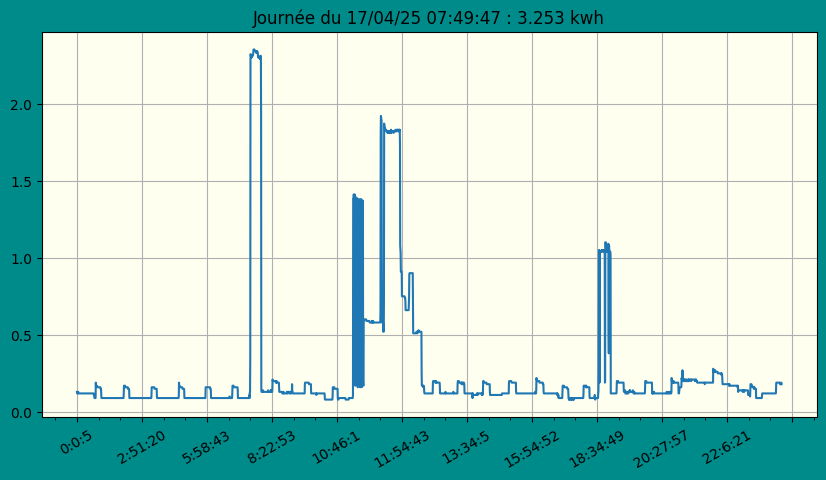

In [737]:
show('17/04/25')

In [738]:
end = time.time()
print(end - start)

27.658117294311523


### 1 kWh window in data of one day
#### df = conso_day

In [739]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999132,27546,0.13,27.546,130.690481,26138859525,2025-04-20 00:00:15.254364,20/04/25
999133,26665,0.14,26.665,135.008438,26138886190,2025-04-20 00:00:41.919364,20/04/25
999134,26229,0.14,26.229,137.252659,26138912419,2025-04-20 00:01:08.148364,20/04/25
999135,26505,0.14,26.505,135.823430,26138938924,2025-04-20 00:01:34.653364,20/04/25
999136,27380,0.13,27.380,131.482834,26138966304,2025-04-20 00:02:02.033364,20/04/25
...,...,...,...,...,...,...,...
999995,28415,0.13,28.415,126.693648,26166895249,2025-04-20 07:47:30.978364,20/04/25
999996,29691,0.12,29.691,121.248863,26166924940,2025-04-20 07:48:00.669364,20/04/25
999997,29329,0.12,29.329,122.745406,26166954269,2025-04-20 07:48:29.998364,20/04/25
999998,29139,0.12,29.139,123.545763,26166983408,2025-04-20 07:48:59.137364,20/04/25


In [740]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [741]:
df = conso_day
len(df)

868

In [742]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-04-20 00:00:15.254364	2025-04-20 07:49:27.631364	7h 49m 12s 	868


In [743]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.292689
dtype: float64

In [744]:
end = time.time()
print(end - start)

27.96635675430298


## mean for data grouped by days

In [745]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.289474
dtype: float64

In [746]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(0.868)

# conso by date


In [747]:
# select day
day = today

#day = '16/08/24'
day

'20/04/25'

In [748]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
999132,27546,0.13,27.546,130.690481,26138859525,2025-04-20 00:00:15.254364,20/04/25
999133,26665,0.14,26.665,135.008438,26138886190,2025-04-20 00:00:41.919364,20/04/25
999134,26229,0.14,26.229,137.252659,26138912419,2025-04-20 00:01:08.148364,20/04/25
999135,26505,0.14,26.505,135.823430,26138938924,2025-04-20 00:01:34.653364,20/04/25
999136,27380,0.13,27.380,131.482834,26138966304,2025-04-20 00:02:02.033364,20/04/25
...,...,...,...,...,...,...,...
999995,28415,0.13,28.415,126.693648,26166895249,2025-04-20 07:47:30.978364,20/04/25
999996,29691,0.12,29.691,121.248863,26166924940,2025-04-20 07:48:00.669364,20/04/25
999997,29329,0.12,29.329,122.745406,26166954269,2025-04-20 07:48:29.998364,20/04/25
999998,29139,0.12,29.139,123.545763,26166983408,2025-04-20 07:48:59.137364,20/04/25


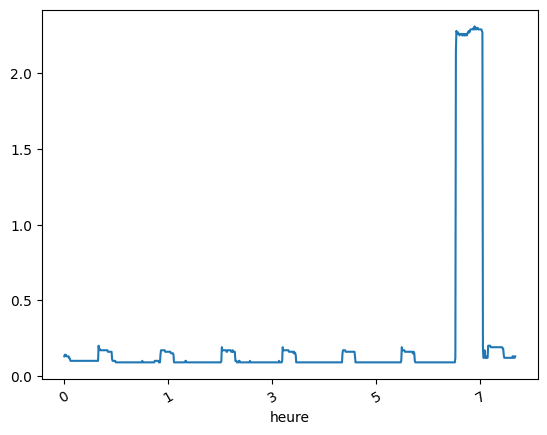

In [749]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [750]:
end = time.time()
print(end - start)

28.556272506713867


### grouped by 'heure'

In [751]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 868 entries, 999132 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   868 non-null    int64         
 1   kWh        868 non-null    float64       
 2   sec        868 non-null    float64       
 3   Wh         868 non-null    float64       
 4   cumul(ms)  868 non-null    int64         
 5   dates      868 non-null    datetime64[ns]
 6   days       868 non-null    object        
 7   heure      868 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 61.0+ KB


In [752]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,27546,0.13,27.546,130.690481,26138859525,2025-04-20 00:00:15.254364,20/04/25
0,26665,0.14,26.665,135.008438,26138886190,2025-04-20 00:00:41.919364,20/04/25
0,26229,0.14,26.229,137.252659,26138912419,2025-04-20 00:01:08.148364,20/04/25
0,26505,0.14,26.505,135.823430,26138938924,2025-04-20 00:01:34.653364,20/04/25
0,27380,0.13,27.380,131.482834,26138966304,2025-04-20 00:02:02.033364,20/04/25
...,...,...,...,...,...,...,...
7,28415,0.13,28.415,126.693648,26166895249,2025-04-20 07:47:30.978364,20/04/25
7,29691,0.12,29.691,121.248863,26166924940,2025-04-20 07:48:00.669364,20/04/25
7,29329,0.12,29.329,122.745406,26166954269,2025-04-20 07:48:29.998364,20/04/25


In [753]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [754]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0    112
1    104
2     97
3     99
4    103
5    102
6    102
7    149
Name: kWh, dtype: int64

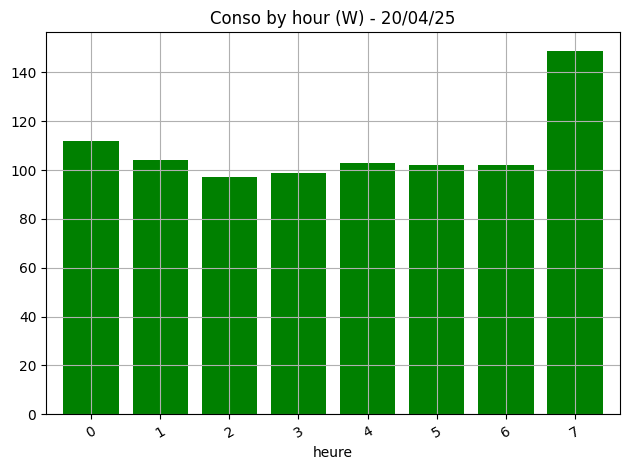

In [755]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [756]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304 entries, 21/06/24 to 20/04/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     304 non-null    float64
dtypes: float64(1)
memory usage: 4.8+ KB


In [757]:
# give the periods of 1 kwh in a day
period()

2025-04-20 00:00:15.254364	2025-04-20 07:49:27.631364	7h 49m 12s 	868


In [758]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [759]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [760]:
df_grp.mean()


kWh    3.289474
dtype: float64

In [761]:
df_grp.head()


,kWh
days,
21/06/24,1.575
22/06/24,2.999
23/06/24,3.502
24/06/24,3.628
25/06/24,3.519


In [762]:
df_grp.tail()


,kWh
days,
16/04/25,3.290
17/04/25,3.253
18/04/25,2.850
19/04/25,3.523
20/04/25,0.868


In [763]:
end = time.time()
print(end - start)

29.758784770965576


# plot les 100 derniers jours


In [764]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.53864
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

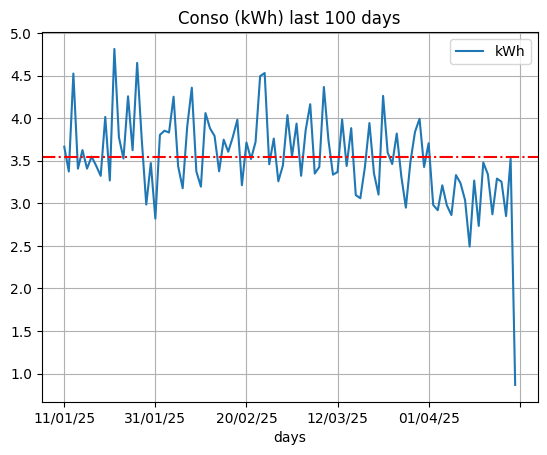

In [765]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label='moyenne')
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [766]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,0.868
max,4.812


In [767]:
end = time.time()
print(end - start)

30.356119394302368


In [768]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('21/03/25', '15/04/25')

In [769]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.286767
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

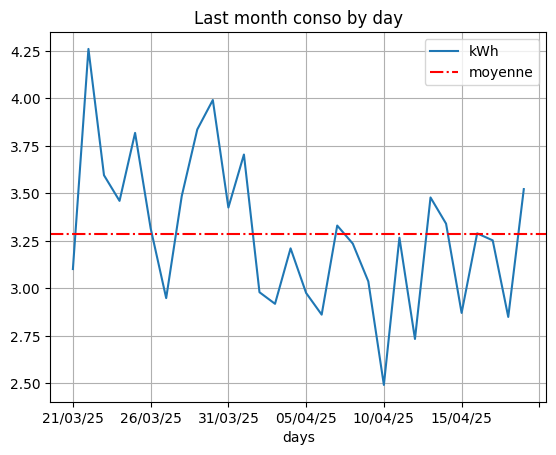

In [770]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label='moyenne')
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [771]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 22/03/25 4.261
Min : 10/04/25 2.492


# Temps de conso par tranche de 1 kWh

In [772]:

tranches = len(df)//1000
tranches+1


1

In [773]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-04-20 00:00:15.254364	2025-04-20 07:49:27.631364	7h 49m 12s 	868


('07:49:47', 0.868, 868)

In [774]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 868 entries, 999132 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   868 non-null    int64         
 1   kWh        868 non-null    float64       
 2   sec        868 non-null    float64       
 3   Wh         868 non-null    float64       
 4   cumul(ms)  868 non-null    int64         
 5   dates      868 non-null    datetime64[ns]
 6   days       868 non-null    object        
 7   heure      868 non-null    object        
 8   hours      868 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 67.8+ KB


In [775]:
conso_hours['heure'], conso_hours['hours']

(999132    0
 999133    0
 999134    0
 999135    0
 999136    0
          ..
 999995    7
 999996    7
 999997    7
 999998    7
 999999    7
 Name: heure, Length: 868, dtype: object,
 999132    00
 999133    00
 999134    00
 999135    00
 999136    00
           ..
 999995    07
 999996    07
 999997    07
 999998    07
 999999    07
 Name: hours, Length: 868, dtype: object)

In [776]:
end = time.time()
print(end - start)

31.331329345703125


# select number of days to display


In [777]:
span = 30
#df_grp.tail(span)

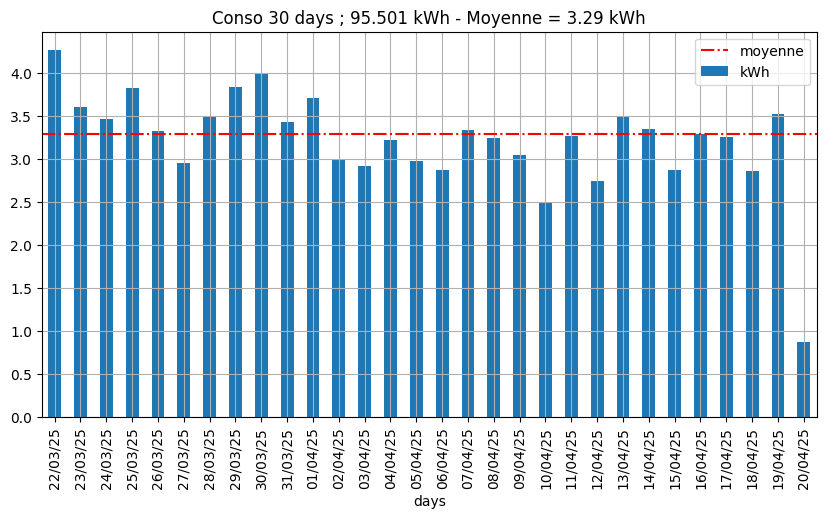

In [778]:

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span).iloc[-31:-1]),2)
conso_mois = sum(df_grp.tail(span).iloc[-31:-1]['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


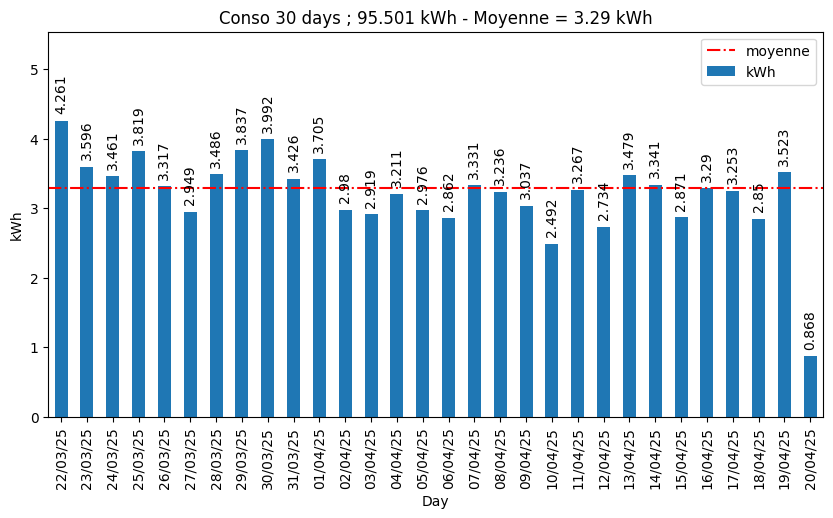

In [779]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [780]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
22/03/25    4.261
23/03/25    3.596
24/03/25    3.461
25/03/25    3.819
26/03/25    3.317
27/03/25    2.949
28/03/25    3.486
29/03/25    3.837
30/03/25    3.992
31/03/25    3.426
01/04/25    3.705
02/04/25    2.980
03/04/25    2.919
04/04/25    3.211
05/04/25    2.976
06/04/25    2.862
07/04/25    3.331
08/04/25    3.236
09/04/25    3.037
10/04/25    2.492
11/04/25    3.267
12/04/25    2.734
13/04/25    3.479
14/04/25    3.341
15/04/25    2.871
16/04/25    3.290
17/04/25    3.253
18/04/25    2.850
19/04/25    3.523
20/04/25    0.868
Name: kWh, dtype: float64

In [781]:
x_labels=df_grp.tail(span).index
x_labels

Index(['22/03/25', '23/03/25', '24/03/25', '25/03/25', '26/03/25', '27/03/25',
       '28/03/25', '29/03/25', '30/03/25', '31/03/25', '01/04/25', '02/04/25',
       '03/04/25', '04/04/25', '05/04/25', '06/04/25', '07/04/25', '08/04/25',
       '09/04/25', '10/04/25', '11/04/25', '12/04/25', '13/04/25', '14/04/25',
       '15/04/25', '16/04/25', '17/04/25', '18/04/25', '19/04/25', '20/04/25'],
      dtype='object', name='days')

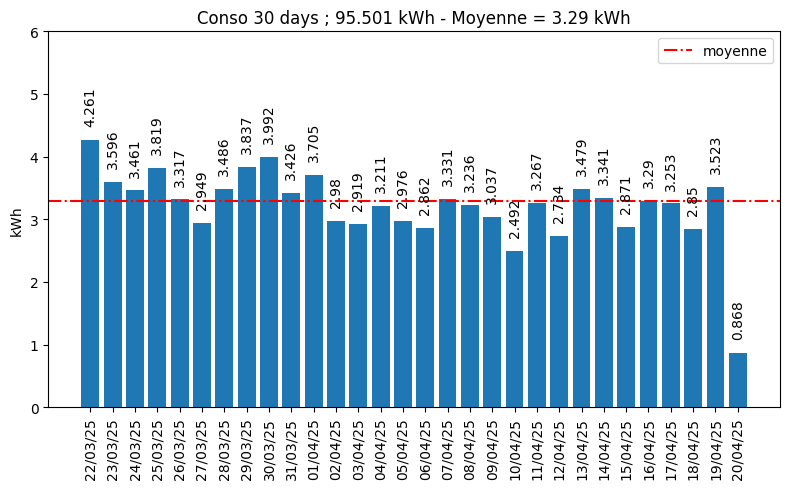

In [782]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [783]:
end = time.time()
print(end - start)

36.03034019470215


In [784]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

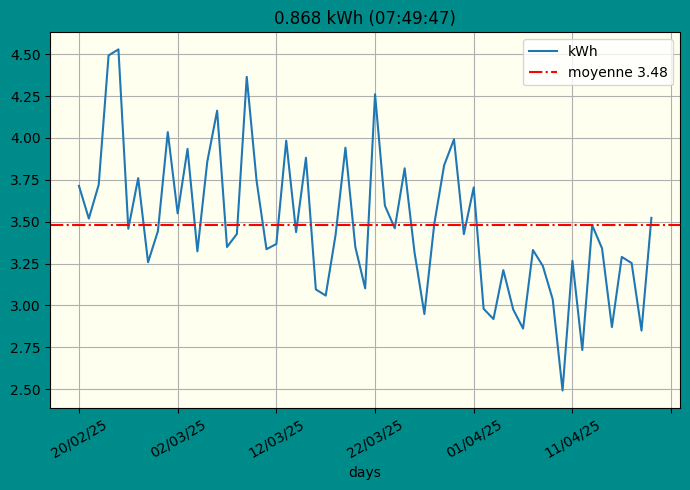

In [785]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

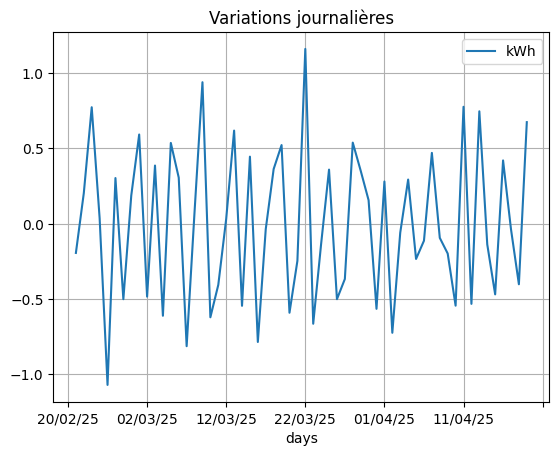

In [786]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [787]:
end = time.time()
print(end - start)

37.53817868232727


# Data from 21/08/23

In [788]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,39195,0.09,39.195,91.848450,39195,2024-06-21 11:13:14.924364,21/06/24,11,2024-06,21
1,39117,0.09,39.117,92.031598,78312,2024-06-21 11:13:54.041364,21/06/24,11,2024-06,21
2,39113,0.09,39.113,92.041009,117425,2024-06-21 11:14:33.154364,21/06/24,11,2024-06,21
3,39007,0.09,39.007,92.291127,156432,2024-06-21 11:15:12.161364,21/06/24,11,2024-06,21
4,39120,0.09,39.120,92.024540,195552,2024-06-21 11:15:51.281364,21/06/24,11,2024-06,21
...,...,...,...,...,...,...,...,...,...,...
999995,28415,0.13,28.415,126.693648,26166895249,2025-04-20 07:47:30.978364,20/04/25,07,2025-04,20
999996,29691,0.12,29.691,121.248863,26166924940,2025-04-20 07:48:00.669364,20/04/25,07,2025-04,20
999997,29329,0.12,29.329,122.745406,26166954269,2025-04-20 07:48:29.998364,20/04/25,07,2025-04,20
999998,29139,0.12,29.139,123.545763,26166983408,2025-04-20 07:48:59.137364,20/04/25,07,2025-04,20


In [789]:
end = time.time()
print(end - start)

80.89975666999817


In [790]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04'])

# define month to show

<Axes: xlabel='day'>

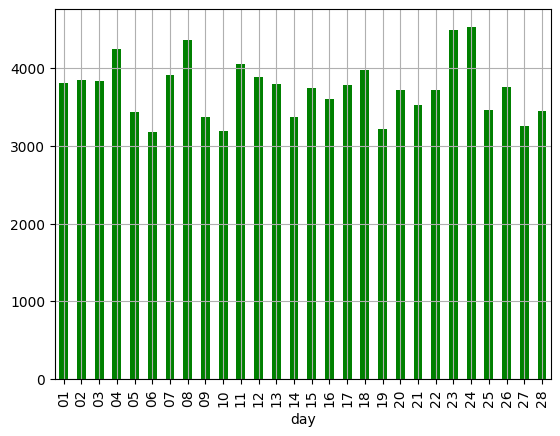

In [791]:
month=conso_grouped_by_month.get_group('2025-02')
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

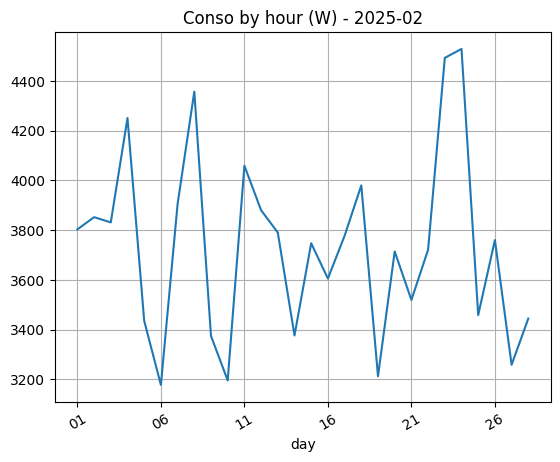

In [792]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [793]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

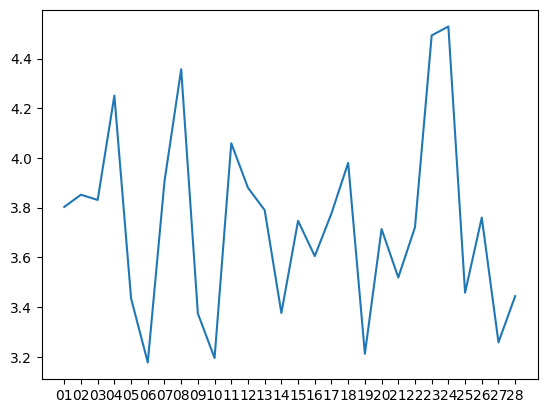

In [794]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)

In [795]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [796]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [797]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-06,27495,27495,27495
2024-07,99394,99394,99394
2024-08,117328,117328,117328
2024-09,69765,69765,69765
2024-10,73525,73525,73525
2024-11,108514,108514,108514
2024-12,113773,113773,113773
2025-01,113610,113610,113610
2025-02,104502,104502,104502


In [798]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [799]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [800]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/06/24,1575
22/06/24,2999
23/06/24,3502
24/06/24,3628
25/06/24,3519
...,...
16/04/25,3290
17/04/25,3253
18/04/25,2850


In [801]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,39195,0.09,39.195,91.848450,39195,2024-06-21 11:13:14.924364,21/06/24,11,2024-06,21
1,39117,0.09,39.117,92.031598,78312,2024-06-21 11:13:54.041364,21/06/24,11,2024-06,21
2,39113,0.09,39.113,92.041009,117425,2024-06-21 11:14:33.154364,21/06/24,11,2024-06,21
3,39007,0.09,39.007,92.291127,156432,2024-06-21 11:15:12.161364,21/06/24,11,2024-06,21
4,39120,0.09,39.120,92.024540,195552,2024-06-21 11:15:51.281364,21/06/24,11,2024-06,21
...,...,...,...,...,...,...,...,...,...,...
999995,28415,0.13,28.415,126.693648,26166895249,2025-04-20 07:47:30.978364,20/04/25,07,2025-04,20
999996,29691,0.12,29.691,121.248863,26166924940,2025-04-20 07:48:00.669364,20/04/25,07,2025-04,20
999997,29329,0.12,29.329,122.745406,26166954269,2025-04-20 07:48:29.998364,20/04/25,07,2025-04,20
999998,29139,0.12,29.139,123.545763,26166983408,2025-04-20 07:48:59.137364,20/04/25,07,2025-04,20


In [802]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
21/06/24 11    0       21/06/24    11  0.09
               1       21/06/24    11  0.09
               2       21/06/24    11  0.09
               3       21/06/24    11  0.09
               4       21/06/24    11  0.09
...                         ...   ...   ...
20/04/25 07    999995  20/04/25    07  0.13
               999996  20/04/25    07  0.12
               999997  20/04/25    07  0.12
               999998  20/04/25    07  0.12
               999999  20/04/25    07  0.13

[1000000 rows x 3 columns]

In [803]:
groupallbyday.indices.keys()

dict_keys(['21/06/24', '22/06/24', '23/06/24', '24/06/24', '25/06/24', '26/06/24', '27/06/24', '28/06/24', '29/06/24', '30/06/24', '01/07/24', '02/07/24', '03/07/24', '04/07/24', '05/07/24', '06/07/24', '07/07/24', '08/07/24', '09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/0

In [804]:
groupallbydayhours.indices.keys()

dict_keys([('21/06/24', '11'), ('21/06/24', '12'), ('21/06/24', '13'), ('21/06/24', '14'), ('21/06/24', '15'), ('21/06/24', '16'), ('21/06/24', '17'), ('21/06/24', '18'), ('21/06/24', '19'), ('21/06/24', '20'), ('21/06/24', '21'), ('21/06/24', '22'), ('21/06/24', '23'), ('22/06/24', '11'), ('22/06/24', '12'), ('22/06/24', '13'), ('22/06/24', '14'), ('22/06/24', '15'), ('22/06/24', '16'), ('22/06/24', '17'), ('22/06/24', '18'), ('22/06/24', '19'), ('22/06/24', '20'), ('22/06/24', '21'), ('22/06/24', '22'), ('22/06/24', '23'), ('22/06/24', '00'), ('22/06/24', '01'), ('22/06/24', '02'), ('22/06/24', '03'), ('22/06/24', '04'), ('22/06/24', '05'), ('22/06/24', '06'), ('22/06/24', '07'), ('22/06/24', '08'), ('22/06/24', '09'), ('22/06/24', '10'), ('23/06/24', '11'), ('23/06/24', '12'), ('23/06/24', '13'), ('23/06/24', '14'), ('23/06/24', '15'), ('23/06/24', '16'), ('23/06/24', '17'), ('23/06/24', '18'), ('23/06/24', '19'), ('23/06/24', '20'), ('23/06/24', '21'), ('23/06/24', '22'), ('23/06/2

In [805]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/06/24,1575,1575
22/06/24,2999,2999
23/06/24,3502,3502
24/06/24,3628,3628
25/06/24,3519,3519
...,...,...
16/04/25,3290,3290
17/04/25,3253,3253
18/04/25,2850,2850


In [806]:
grp_by_day['kWh'].cumsum()

days
21/06/24       1575
22/06/24       4574
23/06/24       8076
24/06/24      11704
25/06/24      15223
             ...   
16/04/25     989506
17/04/25     992759
18/04/25     995609
19/04/25     999132
20/04/25    1000000
Name: kWh, Length: 304, dtype: int64

In [807]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/06/24 11      82
         12     102
         13     165
         14     135
         15     126
...             ...
20/04/25 03      99
         04     103
         05     102
         06     102
         07     149

[7269 rows x 1 columns]

In [808]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/06/24  11            82
          12           184
          13           349
          14           484
          15           610
                    ...   
20/04/25  03        999544
          04        999647
          05        999749
          06        999851
          07       1000000
Name: kWh, Length: 7269, dtype: int64

In [809]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
21/06/24 11      82      82   NaN
         12     102     184  20.0
         13     165     349  63.0
         14     135     484 -30.0
         15     126     610  -9.0
...             ...     ...   ...
20/04/25 03      99     412   2.0
         04     103     515   4.0
         05     102     617  -1.0
         06     102     719   0.0
         07     149     868  47.0

[7269 rows x 3 columns]

In [810]:
today, grp_by_dayhours.loc[today]

('20/04/25',
        kWh  cumsum  diff
 hours                   
 00     112     112   NaN
 01     104     216  -8.0
 02      97     313  -7.0
 03      99     412   2.0
 04     103     515   4.0
 05     102     617  -1.0
 06     102     719   0.0
 07     149     868  47.0)

Text(0.5, 1.0, 'Cumul journalier')

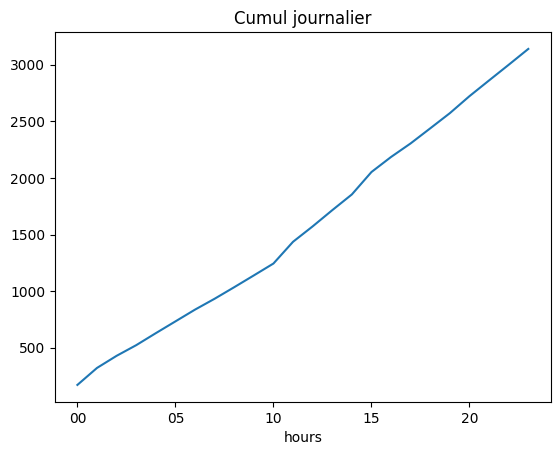

In [811]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

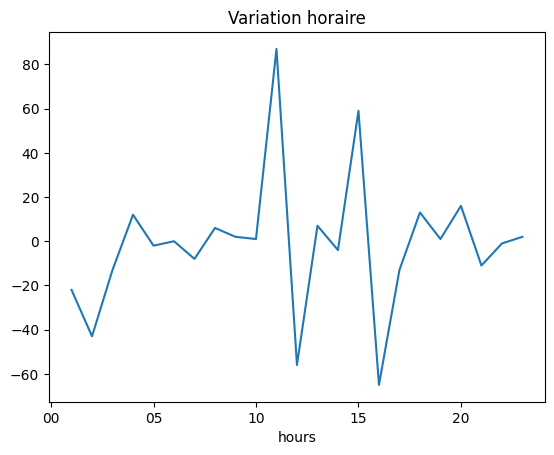

In [812]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [813]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

304

In [814]:
df_grp.tail(n)['kWh'].describe()


count    304.000000
mean       3.289474
std        0.766621
min        0.868000
25%        3.093750
50%        3.466000
75%        3.786250
max        4.812000
Name: kWh, dtype: float64

In [815]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [816]:
n, np.nanmean(df_grp.tail(n))

(304, np.float64(3.289473684210526))

Text(0.5, 1.0, '304 days')

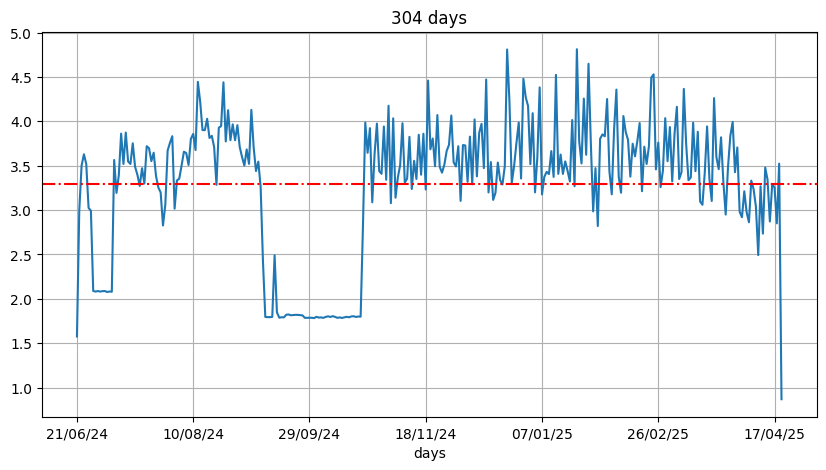

In [817]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

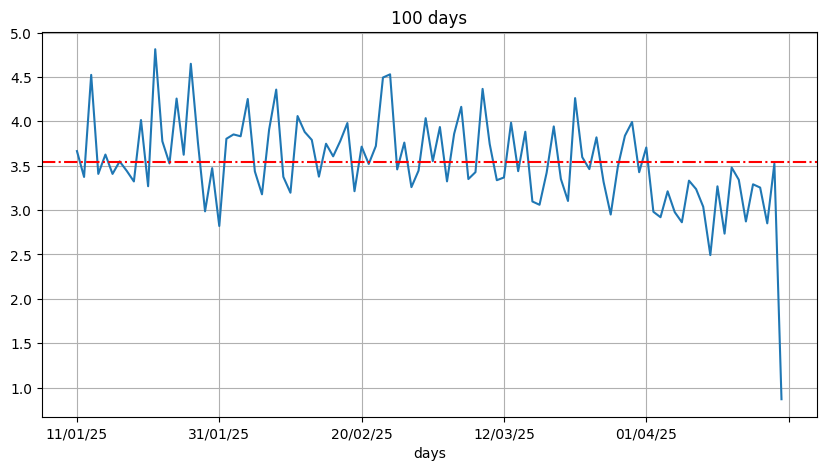

In [818]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [819]:
np.nanmean(df_grp.tail(span))

np.float64(3.5386400000000005)

In [820]:
df_grp['kWh']

days
21/06/24    1.575
22/06/24    2.999
23/06/24    3.502
24/06/24    3.628
25/06/24    3.519
            ...  
16/04/25    3.290
17/04/25    3.253
18/04/25    2.850
19/04/25    3.523
20/04/25    0.868
Name: kWh, Length: 304, dtype: float64

In [821]:
df_grp.describe()

,kWh
count,304.000000
mean,3.289474
std,0.766621
min,0.868000
25%,3.093750
50%,3.466000
75%,3.786250
max,4.812000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

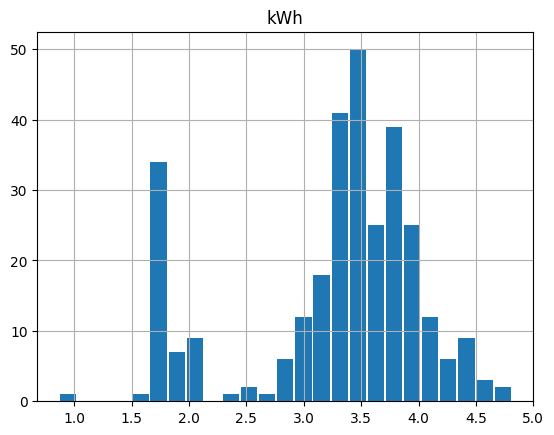

In [822]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [823]:
df_grp.tail(span)['kWh']

days
11/01/25    3.664
12/01/25    3.373
13/01/25    4.523
14/01/25    3.407
15/01/25    3.625
            ...  
16/04/25    3.290
17/04/25    3.253
18/04/25    2.850
19/04/25    3.523
20/04/25    0.868
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [824]:
day

'20/04/25'

In [825]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,112,112,NaN
01,104,216,-8.0
02,97,313,-7.0
03,99,412,2.0
04,103,515,4.0
05,102,617,-1.0
06,102,719,0.0
07,149,868,47.0


In [826]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


8

In [827]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 9)

In [828]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [829]:
grp_by_dayhours.loc[day,'days'].values

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [830]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
Name: days, dtype: float64

In [831]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [832]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 00 to 07
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     8 non-null      int64  
 1   cumsum  8 non-null      int64  
 2   diff    7 non-null      float64
 3   days    8 non-null      float64
dtypes: float64(2), int64(2)
memory usage: 320.0+ bytes


In [833]:
grp_by_dayhours.loc[day,'days']

hours
00    1.0
01    2.0
02    3.0
03    4.0
04    5.0
05    6.0
06    7.0
07    8.0
Name: days, dtype: float64

In [834]:
day

'20/04/25'

In [835]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,112,112,NaN,1.0
01,104,216,-8.0,2.0
02,97,313,-7.0,3.0
03,99,412,2.0,4.0
04,103,515,4.0,5.0
05,102,617,-1.0,6.0
06,102,719,0.0,7.0
07,149,868,47.0,8.0


In [836]:
kwh = grp_by_dayhours.loc[day][['kWh']]
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_15908\3891495459.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.int64(868)

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '20/04/25: kWh    868\ndtype: int64')

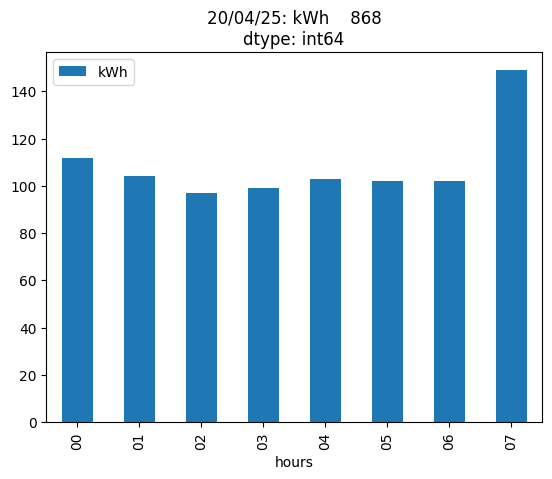

In [837]:
kwh.plot.bar()
plt.title(f'{day}: {np.sum(kwh)}')

In [838]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07'], dtype='object', name='hours')

# Conso du jour


In [839]:

grp_by_dayhours.count()

kWh       7269
cumsum    7269
diff      6965
days         8
dtype: int64

'22/01/25'

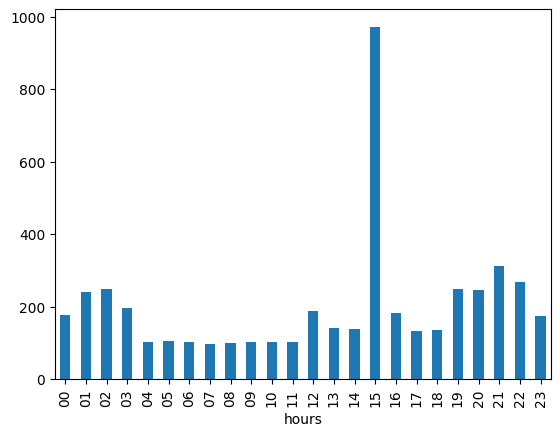

In [840]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [841]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [842]:
df_grp.tail(7)['kWh']

days
14/04/25    3.341
15/04/25    2.871
16/04/25    3.290
17/04/25    3.253
18/04/25    2.850
19/04/25    3.523
20/04/25    0.868
Name: kWh, dtype: float64

Total= 353.864 , Moyenne= 3.5386400000000005


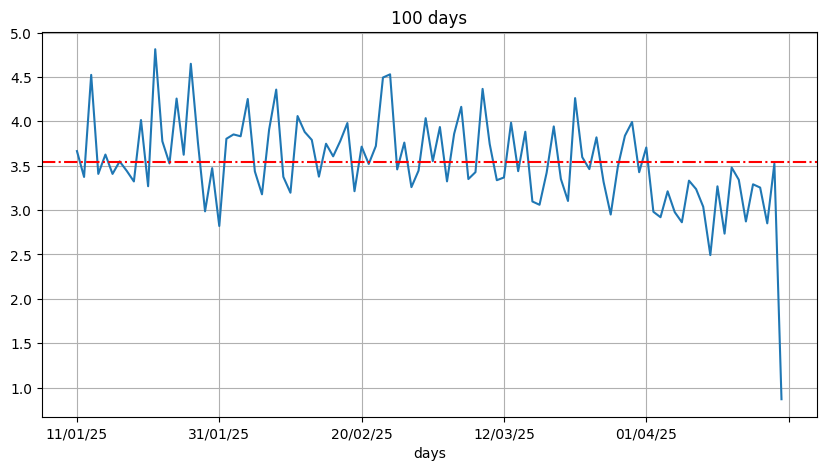

In [843]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [844]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

95.6061475276947


# Today

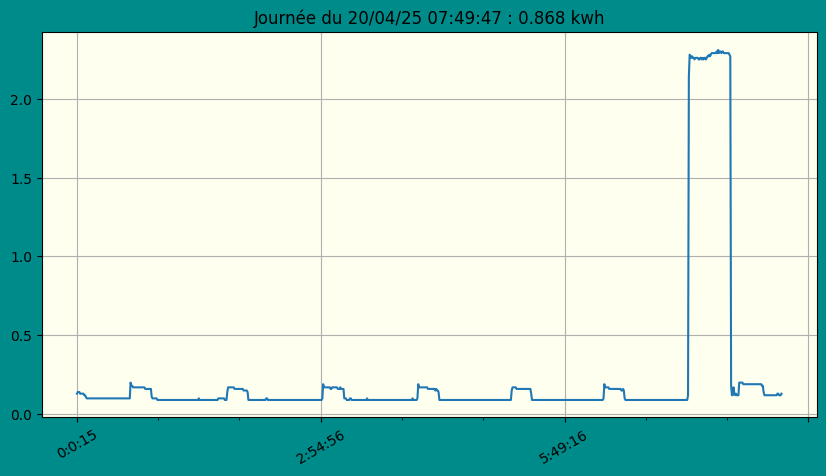

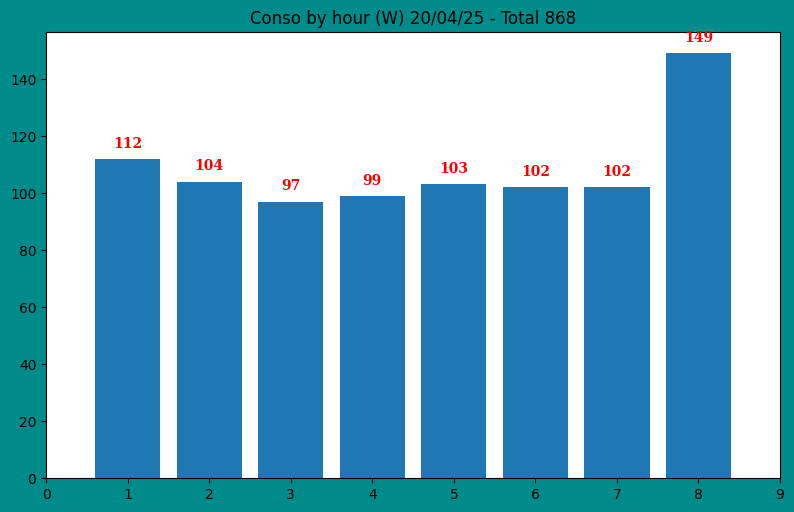

In [845]:
show(today,bgcolor='ivory')
conso_by_hour(today)

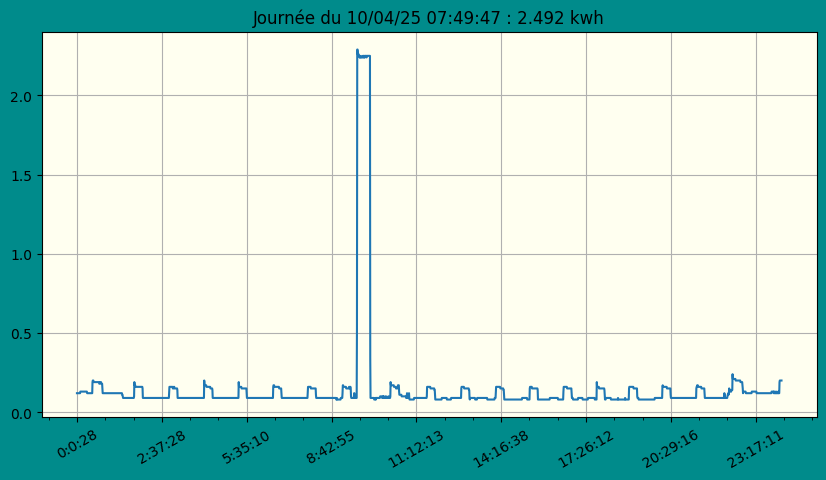

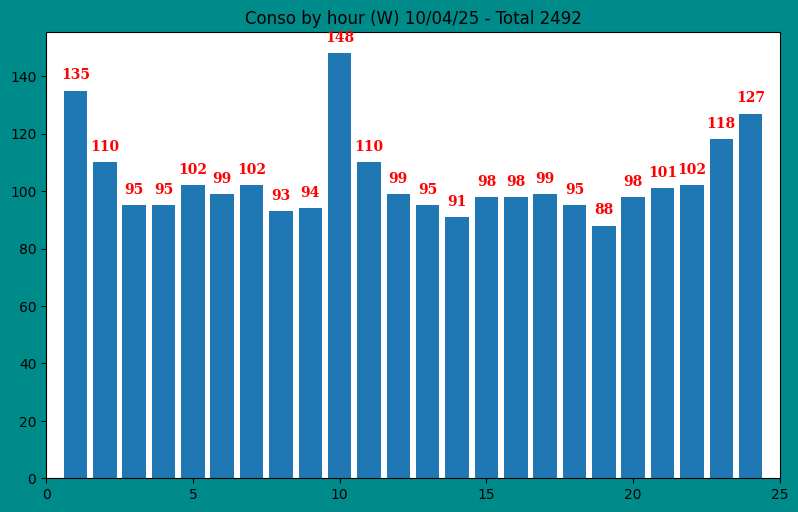

In [846]:
day = '10/04/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4812)

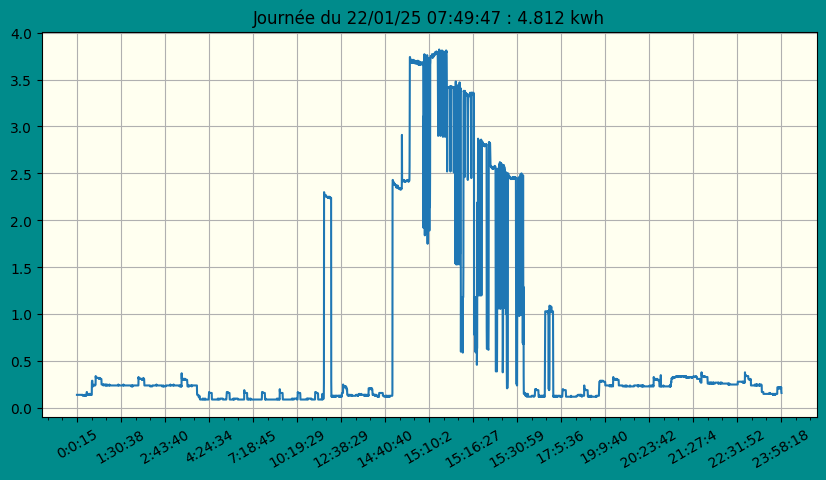

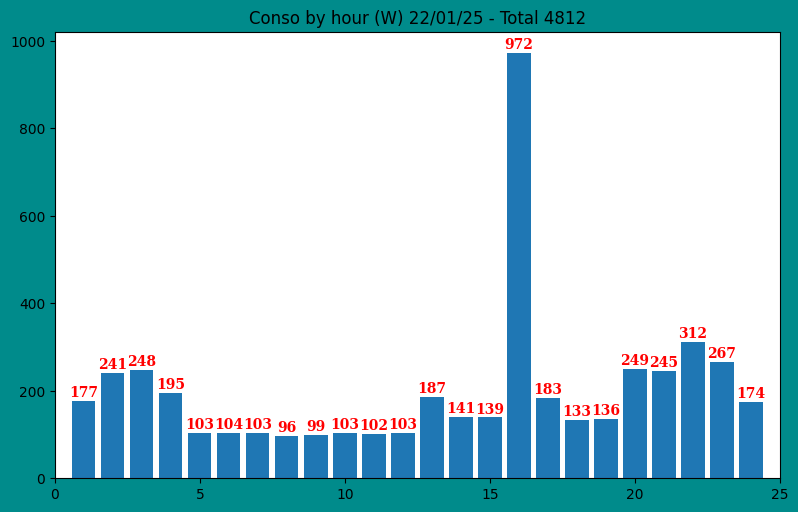

In [847]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

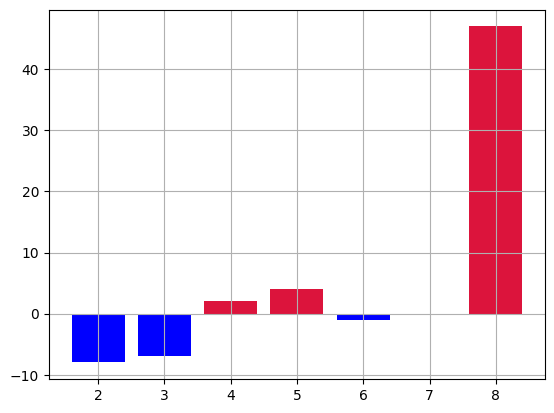

In [848]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

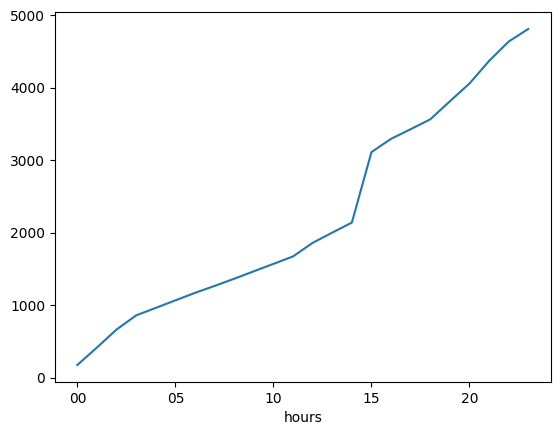

In [849]:
data.cumsum().plot()


<Axes: xlabel='hours'>

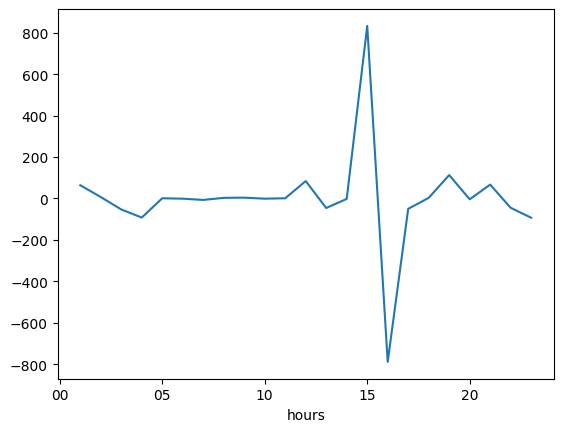

In [850]:
# evolution par heure
data.diff().plot()

In [851]:
data.diff().describe()

count     23.000000
mean      -0.130435
std      249.685130
min     -789.000000
25%      -45.500000
50%       -1.000000
75%        5.500000
max      833.000000
Name: kWh, dtype: float64

<Axes: >

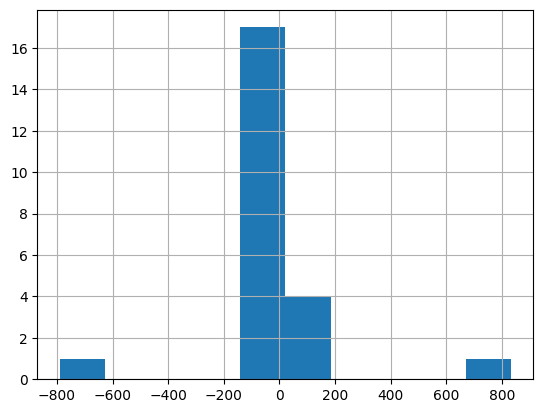

In [852]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [853]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_settings.json',
 '__pycache__',
 'test_c

# list store files csv


In [854]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

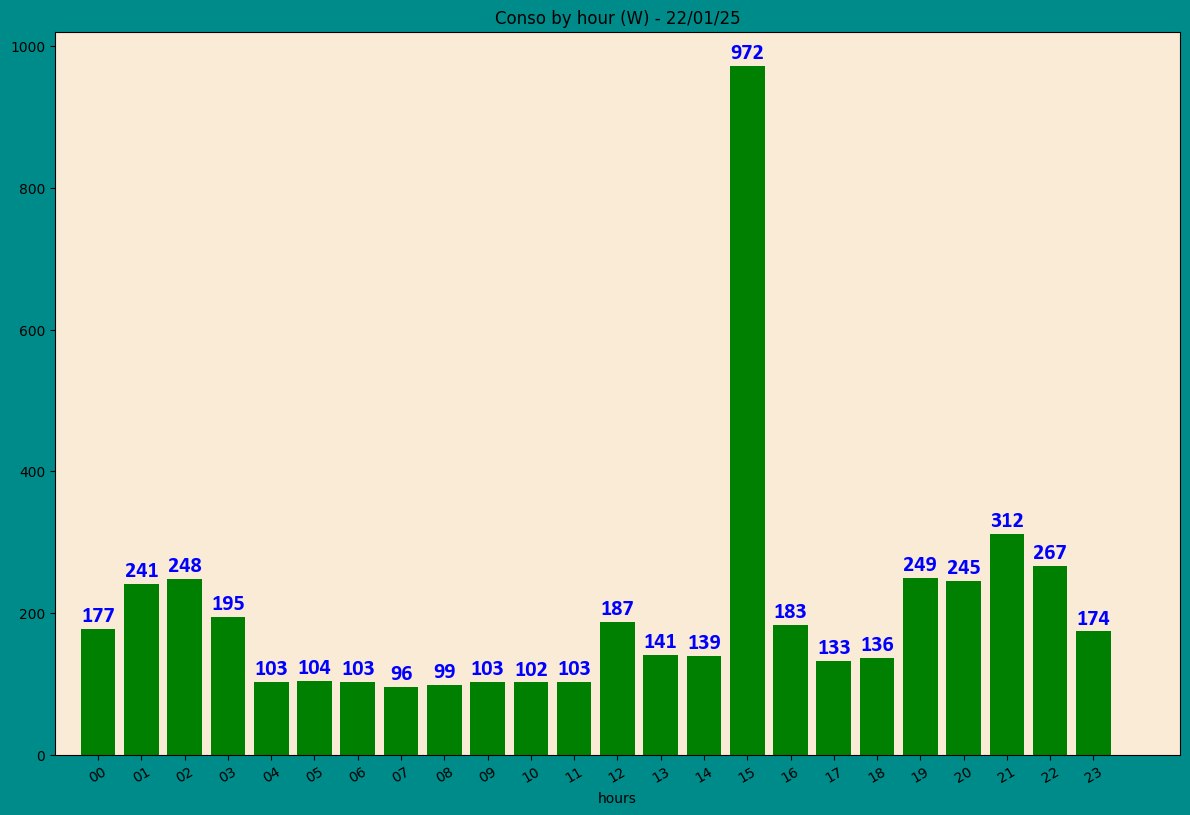

In [855]:
day,conso_byhour(day)

In [856]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


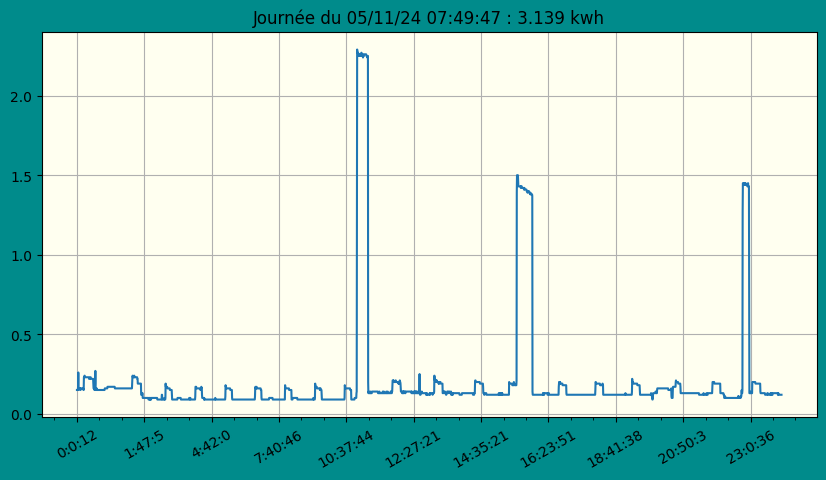

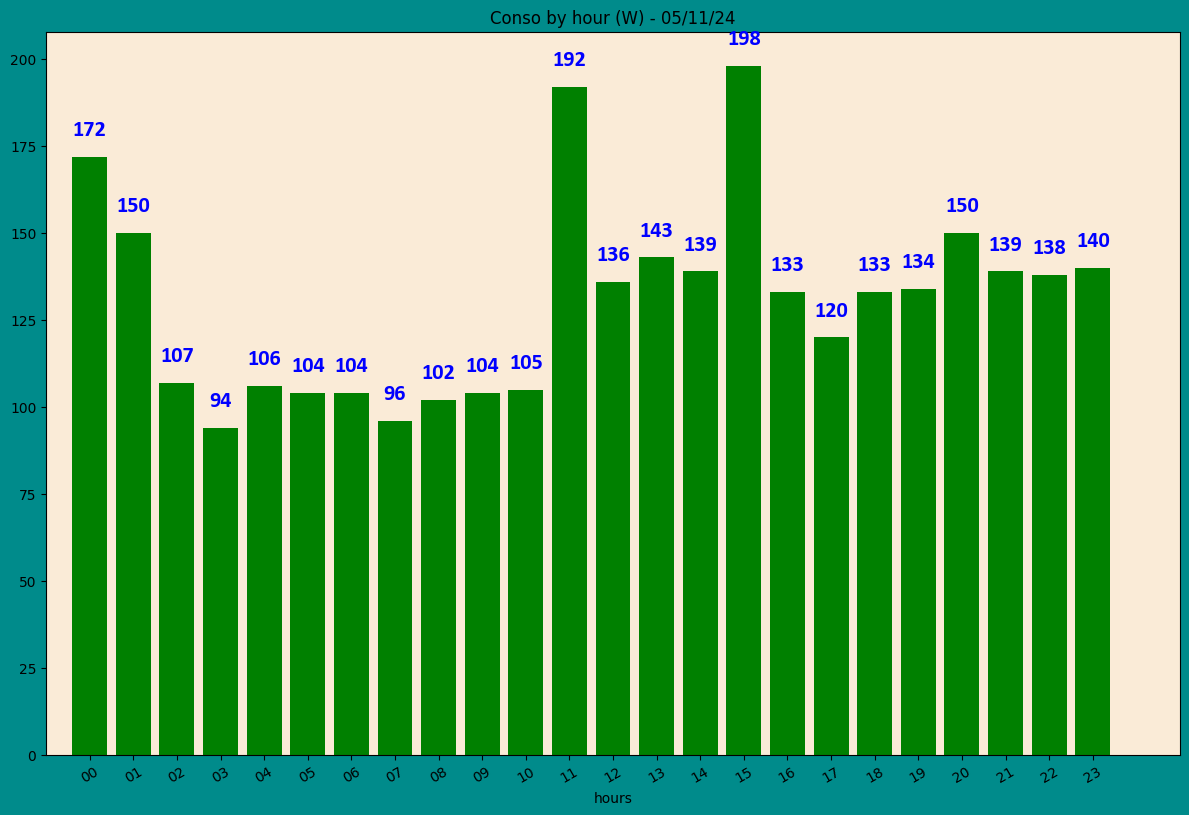

In [857]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [858]:
month

,day,hours,months,kWh
723404,01,00,2025-02,0.16
723405,01,00,2025-02,0.16
723406,01,00,2025-02,0.16
723407,01,00,2025-02,0.16
723408,01,00,2025-02,0.16
...,...,...,...,...
827901,28,23,2025-02,0.17
827902,28,23,2025-02,0.19
827903,28,23,2025-02,0.20
827904,28,23,2025-02,0.20


In [859]:
month.describe()


,kWh
count,104502.000000
mean,0.334553
std,0.555048
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.650000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

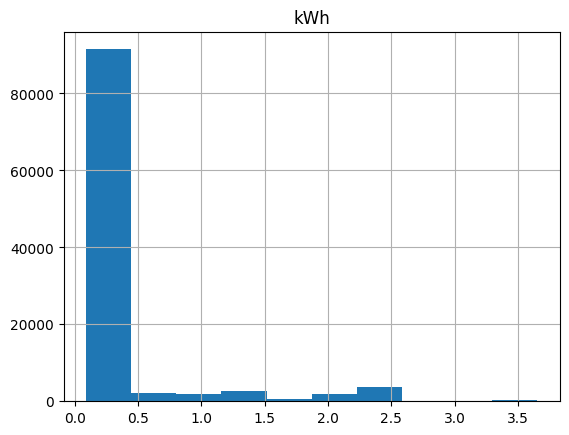

In [860]:
month.hist()

<Axes: >

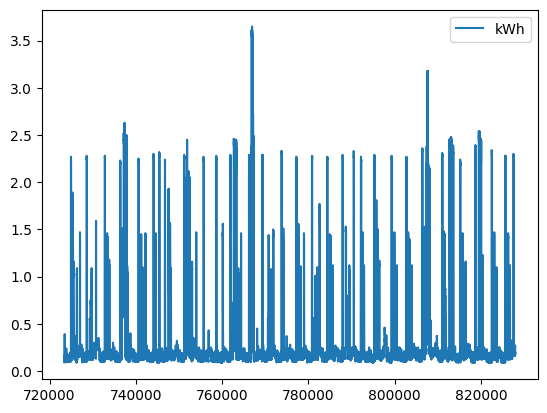

In [861]:
month.plot()

In [862]:
# index with max conso in this month
month.idxmax().kWh

np.int64(766927)

In [863]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       824462
hours     726997
months    723404
kWh       766927
dtype: int64

In [864]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [865]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
21/06/24 11      82      82   NaN   NaN
         12     102     184  20.0   NaN
         13     165     349  63.0   NaN
         14     135     484 -30.0   NaN
         15     126     610  -9.0   NaN
...             ...     ...   ...   ...
20/04/25 03      99     412   2.0   4.0
         04     103     515   4.0   5.0
         05     102     617  -1.0   6.0
         06     102     719   0.0   7.0
         07     149     868  47.0   8.0

[7269 rows x 4 columns]

In [866]:
month

,day,hours,months,kWh
723404,01,00,2025-02,0.16
723405,01,00,2025-02,0.16
723406,01,00,2025-02,0.16
723407,01,00,2025-02,0.16
723408,01,00,2025-02,0.16
...,...,...,...,...
827901,28,23,2025-02,0.17
827902,28,23,2025-02,0.19
827903,28,23,2025-02,0.20
827904,28,23,2025-02,0.20


In [867]:
month.idxmax()


day       824462
hours     726997
months    723404
kWh       766927
dtype: int64

In [868]:
month.loc[month.idxmax().kWh]


day            12
hours          15
months    2025-02
kWh          3.65
Name: 766927, dtype: object

In [869]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       154
          01       114
          02       102
          03       108
          04       111
          05       111
          06        98
          07       110
          08       111
          09       109
          10       172
          11       144
          12       149
          13       146
          14       192
          15       143
          16       196
          17       158
          18       149
          19       143
          20       158
          21       226
          22       174
          23       166
Name: kWh, dtype: int64

In [870]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'21'

<Axes: xlabel='days,hours'>

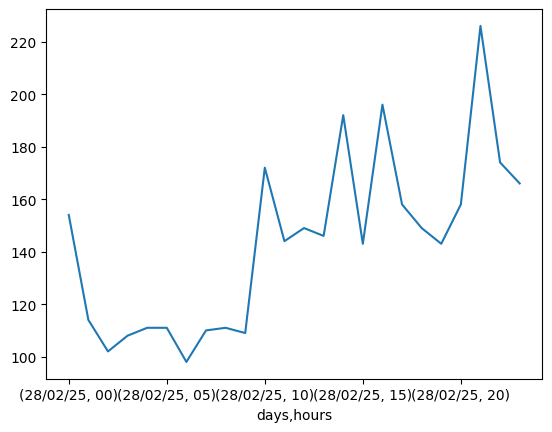

In [871]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [872]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [873]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [874]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [875]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB